# Technical Indicatiors Analysis (RSI)

Aight this uses RSI to find overbought or oversold price action as well as MACD and Moving averages to detect movent and volatility.
If RSI drops belo 30 or when MACD crosses above signal line, uses random forest to decide "Hold, Buy, Sell" position
Then uses backtesting to see how the performance of model and strategy performs overtime. 


## Libraries


In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Fetching Data


In [2]:
# Define stock ticker and time period
ticker = "NVDA"  # Can be changed to any stock ticker
period = "5y"   # Can also be changed to "5", "1y", "6mo", "3mo", etc.

# Fetch data
data = yf.Ticker(ticker).history(period=period)
print(f"Downloaded {len(data)} rows of data for {ticker}")
print("\nFirst 5 rows:")
print(data.head())
print("\nLast 5 rows:")
print(data.tail())

# Basic info about the data
print("\nData Overview:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Downloaded 1257 rows of data for NVDA

First 5 rows:
                               Open      High       Low     Close     Volume  \
Date                                                                           
2020-04-17 00:00:00-04:00  7.422654  7.444075  7.147169  7.281175  539120000   
2020-04-20 00:00:00-04:00  7.154641  7.310567  7.105572  7.149909  449388000   
2020-04-21 00:00:00-04:00  7.031844  7.093118  6.653239  6.713018  735160000   
2020-04-22 00:00:00-04:00  6.905309  7.170333  6.859727  7.127491  483356000   
2020-04-23 00:00:00-04:00  7.169585  7.301598  7.049029  7.074186  424160000   

                           Dividends  Stock Splits  
Date                                                
2020-04-17 00:00:00-04:00        0.0           0.0  
2020-04-20 00:00:00-04:00        0.0           0.0  
2020-04-21 00:00:00-04:00        0.0           0.0  
2020-04-22 00:00:00-04:00        0.0           0.0  
2020-04-23 00:00:00-04:00        0.0           0.0  

Last 5 rows:
 

## Quality Check 

In [3]:
# Check for missing values
print("Missing values count:")
print(data.isnull().sum())

# Handle missing values if any
data = data.fillna(method='ffill')  # Forward fill

# Verify data is clean
print("\nAfter handling missing values:")
print(data.isnull().sum())

# Create returns column (percentage change)
data['Returns'] = data['Close'].pct_change() * 100

# Only drop the first row with NaN return
data = data.dropna(subset=['Returns'])

print("\nData with returns column:")
print(data.head())
print(f"\nCurrent data shape: {data.shape}")

Missing values count:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

After handling missing values:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Data with returns column:
                               Open      High       Low     Close     Volume  \
Date                                                                           
2020-04-20 00:00:00-04:00  7.154641  7.310567  7.105572  7.149909  449388000   
2020-04-21 00:00:00-04:00  7.031844  7.093118  6.653239  6.713018  735160000   
2020-04-22 00:00:00-04:00  6.905309  7.170333  6.859727  7.127491  483356000   
2020-04-23 00:00:00-04:00  7.169585  7.301598  7.049029  7.074186  424160000   
2020-04-24 00:00:00-04:00  7.063973  7.215166  6.989248  7.213173  352328000   

                           Dividends  Stock Splits   Returns  
Date             

C:\Users\10yvn\AppData\Local\Temp\ipykernel_54792\1571792243.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Forward fill


In [4]:
# Check for missing values
print("Missing values count:")
print(data.isnull().sum())

# Handle missing values if any
data = data.fillna(method='ffill')  # Forward fill

# Verify data is clean
print("\nAfter handling missing values:")
print(data.isnull().sum())

# Create returns column (percentage change)
data['Returns'] = data['Close'].pct_change() * 100

# Only drop the first row with NaN return
data = data.dropna(subset=['Returns'])

print("\nData with returns column:")
print(data.head())
print(f"\nCurrent data shape: {data.shape}")

Missing values count:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Returns         0
dtype: int64

After handling missing values:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Returns         0
dtype: int64

Data with returns column:
                               Open      High       Low     Close     Volume  \
Date                                                                           
2020-04-21 00:00:00-04:00  7.031844  7.093118  6.653239  6.713018  735160000   
2020-04-22 00:00:00-04:00  6.905309  7.170333  6.859727  7.127491  483356000   
2020-04-23 00:00:00-04:00  7.169585  7.301598  7.049029  7.074186  424160000   
2020-04-24 00:00:00-04:00  7.063973  7.215166  6.989248  7.213173  352328000   
2020-04-27 00:00:00-04:00  7.347680  7.559649  7.323020  7.399738  479388000   

                           Dividends  Stock 

C:\Users\10yvn\AppData\Local\Temp\ipykernel_54792\1571792243.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Forward fill


## Technical Indicators

In [5]:
# Calculate all technical indicators before handling any more missing values
print("Calculating technical indicators...")

# Calculate RSI (Relative Strength Index)
data.ta.rsi(close='Close', length=14, append=True)

# Calculate MACD (Moving Average Convergence Divergence)
data.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)

# Calculate Bollinger Bands
data.ta.bbands(close='Close', length=20, std=2, append=True)

# Calculate Simple Moving Averages
data.ta.sma(close='Close', length=50, append=True)
data.ta.sma(close='Close', length=200, append=True)

# Calculate Exponential Moving Averages
data.ta.ema(close='Close', length=20, append=True)

# Calculate Average True Range (ATR)
data.ta.atr(high='High', low='Low', close='Close', length=14, append=True)

# Calculate On-Balance Volume (OBV)
data.ta.obv(close='Close', volume='Volume', append=True)

# Check the columns we now have
print("\nColumns after adding indicators:")
print(data.columns.tolist())

# Display a sample of the data with indicators
print("\nSample data with indicators:")
print(data.tail())

# Check for missing values after adding indicators
print("\nMissing values after adding indicators:")
print(data.isnull().sum().sum(), "total missing values")

# Fill forward NaN values from indicators requiring lookback periods
data = data.fillna(method='ffill')

# Still need to drop initial rows where indicators couldn't be calculated
# Keep track of the initial shape
initial_shape = data.shape
data = data.dropna()
final_shape = data.shape

print(f"\nRows removed due to indicator calculation requirements: {initial_shape[0] - final_shape[0]}")
print(f"Final dataset shape: {data.shape}")

# Convert indicator columns to numeric if they aren't already
for col in data.columns:
    if col not in ['Dividends', 'Stock Splits']:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Final check for any remaining NaN values
remaining_na = data.isnull().sum().sum()
if remaining_na > 0:
    print(f"Warning: {remaining_na} NaN values still remain. Consider additional cleaning.")
else:
    print("Data is clean with no NaN values.")

Calculating technical indicators...

Columns after adding indicators:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Returns', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'SMA_50', 'SMA_200', 'EMA_20', 'ATRr_14', 'OBV']

Sample data with indicators:
                                 Open        High         Low       Close  \
Date                                                                        
2025-04-10 00:00:00-04:00  109.370003  110.860001   99.150002  107.570000   
2025-04-11 00:00:00-04:00  108.500000  111.550003  107.480003  110.930000   
2025-04-14 00:00:00-04:00  114.110001  114.290001  109.070000  110.709999   
2025-04-15 00:00:00-04:00  110.970001  113.620003  110.500000  112.199997   
2025-04-16 00:00:00-04:00  104.550003  106.790001  100.449997  104.489998   

                              Volume  Dividends  Stock Splits   Returns  \
Date                   

C:\Users\10yvn\AppData\Local\Temp\ipykernel_54792\2027745828.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


## Signal Generation


In [6]:
# Function to generate signals based on RSI
def generate_rsi_signal(row, buy_threshold=30, sell_threshold=70):
    if row['RSI_14'] < buy_threshold:
        return 'BUY'
    elif row['RSI_14'] > sell_threshold:
        return 'SELL'
    else:
        return 'HOLD'

# Apply RSI signal function
data['RSI_Signal'] = data.apply(generate_rsi_signal, axis=1)

# Function to generate signals based on MACD crossover
def generate_macd_signal(row):
    if row['MACD_12_26_9'] > row['MACDs_12_26_9']:
        return 'BUY'
    elif row['MACD_12_26_9'] < row['MACDs_12_26_9']:
        return 'SELL'
    else:
        return 'HOLD'

# Apply MACD signal function
data['MACD_Signal'] = data.apply(generate_macd_signal, axis=1)

# Function to generate signals based on SMA crossover
def generate_sma_signal(row):
    if row['SMA_50'] > row['SMA_200']:  # Golden Cross
        return 'BUY'
    elif row['SMA_50'] < row['SMA_200']:  # Death Cross
        return 'SELL'
    else:
        return 'HOLD'

# Apply SMA signal function
data['SMA_Signal'] = data.apply(generate_sma_signal, axis=1)

# Function to generate combined signal (majority vote)
def generate_combined_signal(row):
    signals = [row['RSI_Signal'], row['MACD_Signal'], row['SMA_Signal']]
    buy_count = signals.count('BUY')
    sell_count = signals.count('SELL')
    hold_count = signals.count('HOLD')
    
    if buy_count > sell_count and buy_count > hold_count:
        return 'BUY'
    elif sell_count > buy_count and sell_count > hold_count:
        return 'SELL'
    else:
        return 'HOLD'

# Apply combined signal function
data['Combined_Signal'] = data.apply(generate_combined_signal, axis=1)

# Display signal distribution
print("RSI Signal Distribution:")
print(data['RSI_Signal'].value_counts())
print("\nMACD Signal Distribution:")
print(data['MACD_Signal'].value_counts())
print("\nSMA Signal Distribution:")
print(data['SMA_Signal'].value_counts())
print("\nCombined Signal Distribution:")
print(data['Combined_Signal'].value_counts())

# Create a numerical target for ML model
data['Signal_Target'] = data['Combined_Signal'].map({'BUY': 1, 'HOLD': 0, 'SELL': -1})

print("\nSample data with signals:")
print(data[['Close', 'RSI_14', 'MACD_12_26_9', 'MACDs_12_26_9', 'SMA_50', 'SMA_200', 
            'RSI_Signal', 'MACD_Signal', 'SMA_Signal', 'Combined_Signal', 'Signal_Target']].tail())

RSI Signal Distribution:
RSI_Signal
HOLD    893
SELL    152
BUY      11
Name: count, dtype: int64

MACD Signal Distribution:
MACD_Signal
BUY     555
SELL    501
Name: count, dtype: int64

SMA Signal Distribution:
SMA_Signal
BUY     845
SELL    211
Name: count, dtype: int64

Combined Signal Distribution:
Combined_Signal
HOLD    519
BUY     439
SELL     98
Name: count, dtype: int64

Sample data with signals:
                                Close     RSI_14  MACD_12_26_9  MACDs_12_26_9  \
Date                                                                            
2025-04-10 00:00:00-04:00  107.570000  46.368888     -4.660319      -4.725857   
2025-04-11 00:00:00-04:00  110.930000  49.199302     -4.000668      -4.580819   
2025-04-14 00:00:00-04:00  110.709999  49.016891     -3.455806      -4.355817   
2025-04-15 00:00:00-04:00  112.199997  50.359266     -2.870677      -4.058789   
2025-04-16 00:00:00-04:00  104.489998  43.915773     -2.994571      -3.845945   

                      

## ML Model

Data shape before feature selection: (1056, 27)

Data shape for modeling: (1056, 14)
Using test_size=0.30 (316 samples)
Training set: (740, 14)
Testing set: (316, 14)

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           0       0.92      0.92      0.92       146
           1       0.93      1.00      0.96       158

    accuracy                           0.93       316
   macro avg       0.62      0.64      0.63       316
weighted avg       0.89      0.93      0.91       316



C:\Users\10yvn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\10yvn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\10yvn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

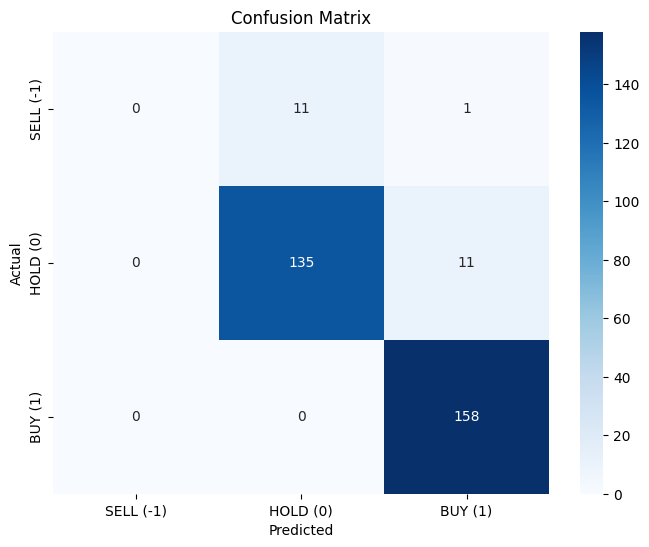


Feature Importance:
          Feature  Importance
3   MACDh_12_26_9    0.218858
0          RSI_14    0.103573
8      BBP_20_2.0    0.099391
12        ATRr_14    0.074194
13            OBV    0.070004
6      BBU_20_2.0    0.057660
4      BBL_20_2.0    0.054244
10        SMA_200    0.052676
11         EMA_20    0.052431
7      BBB_20_2.0    0.051362
5      BBM_20_2.0    0.049696
1    MACD_12_26_9    0.047054
9          SMA_50    0.042820
2   MACDs_12_26_9    0.026037


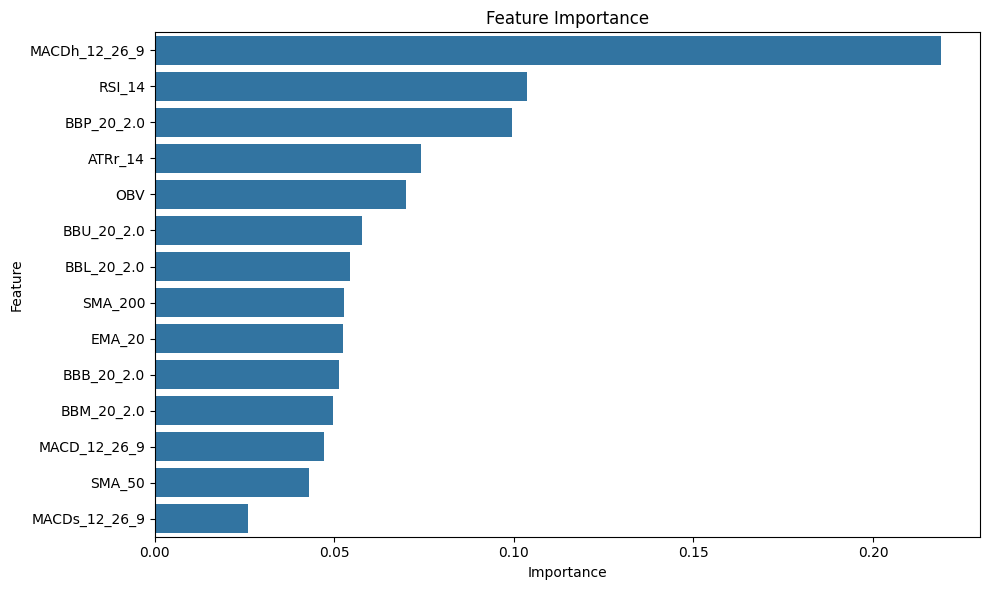

In [7]:
# Print data shape before feature selection
print(f"Data shape before feature selection: {data.shape}")

# Prepare features and target
features = data[[
    'RSI_14', 'MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9',
    'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0',
    'SMA_50', 'SMA_200', 'EMA_20', 'ATRr_14', 'OBV'
]]

target = data['Signal_Target']

print(f"\nData shape for modeling: {features.shape}")

# Check for any remaining NaN values
nan_columns = features.columns[features.isnull().any()].tolist()
if nan_columns:
    print(f"Warning: Found NaN values in columns: {nan_columns}")
    features = features.fillna(method='ffill').fillna(method='bfill')

# Make sure we have enough data for splitting
if len(features) >= 30:  # Need a reasonable minimum number of samples
    # Determine appropriate test size - at least 10 samples, max 30% of data
    test_samples = max(10, int(len(features) * 0.3))
    test_size = test_samples / len(features)
    
    print(f"Using test_size={test_size:.2f} ({test_samples} samples)")
    
    # Split the data into training and testing sets - use time series order (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42, 
        shuffle=False  # Keep time series order
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Testing set: {X_test.shape}")
    
    # Train a Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['SELL (-1)', 'HOLD (0)', 'BUY (1)'], 
                yticklabels=['SELL (-1)', 'HOLD (0)', 'BUY (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
else:
    print(f"ERROR: Only {len(features)} samples available after preprocessing.")
    print("This is not enough data to train a model. Here are some suggestions:")
    print("1. Use a longer time period in your data download (e.g., '10y' instead of '5y')")
    print("2. Fix the missing values earlier in the process instead of dropping rows")
    print("3. Use different indicators that require fewer lookback periods")

## Visualizer

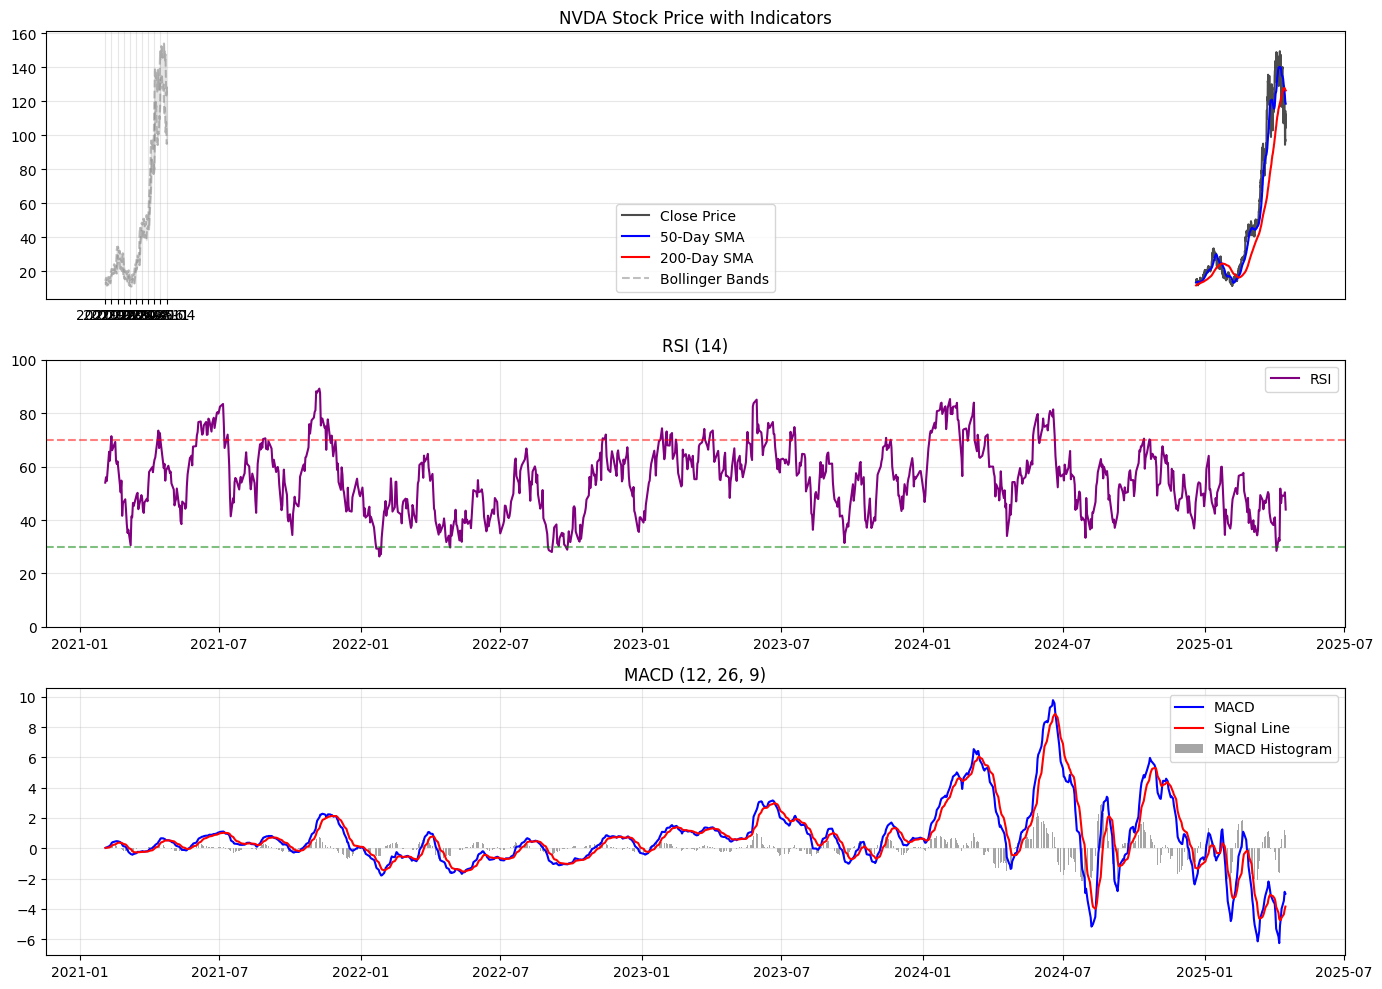

In [8]:
# Create a price chart with indicators - with error handling
plt.figure(figsize=(14, 10))

# Make sure all data is numeric type
for col in ['BBL_20_2.0', 'BBU_20_2.0', 'Close', 'SMA_50', 'SMA_200', 'RSI_14', 
            'MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Stock price and moving averages - subplot 1
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='black', alpha=0.7)
plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='blue')
plt.plot(data.index, data['SMA_200'], label='200-Day SMA', color='red')

# Safely add Bollinger Bands
try:
    # Convert to numpy arrays to avoid date index issues
    x_dates = np.array(range(len(data.index)))
    bb_lower = data['BBL_20_2.0'].values
    bb_upper = data['BBU_20_2.0'].values
    
    plt.fill_between(x_dates, bb_lower, bb_upper, color='gray', alpha=0.2)
    plt.plot(x_dates, bb_lower, '--', color='gray', alpha=0.5, label='Bollinger Bands')
    plt.plot(x_dates, bb_upper, '--', color='gray', alpha=0.5)
    
    # Reset the x-ticks to show dates
    plt.xticks(np.arange(0, len(x_dates), len(x_dates)//10), 
               [data.index[i].strftime('%Y-%m') for i in np.arange(0, len(x_dates), len(x_dates)//10)])
except Exception as e:
    print(f"Warning: Could not plot Bollinger Bands - {e}")
    # Simple alternative
    plt.plot(data.index, data['BBL_20_2.0'], '--', color='gray', alpha=0.5, label='Lower BB')
    plt.plot(data.index, data['BBU_20_2.0'], '--', color='gray', alpha=0.5, label='Upper BB')

plt.legend()
plt.title(f'{ticker} Stock Price with Indicators')
plt.grid(True, alpha=0.3)

# RSI - subplot 2
plt.subplot(3, 1, 2)
plt.plot(data.index, data['RSI_14'], label='RSI', color='purple')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
plt.legend()
plt.title('RSI (14)')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# MACD - subplot 3
plt.subplot(3, 1, 3)
plt.bar(data.index, data['MACDh_12_26_9'], label='MACD Histogram', color='gray', alpha=0.7)
plt.plot(data.index, data['MACD_12_26_9'], label='MACD', color='blue')
plt.plot(data.index, data['MACDs_12_26_9'], label='Signal Line', color='red')
plt.legend()
plt.title('MACD (12, 26, 9)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interactive Plot

In [9]:
# Create an interactive chart with Plotly
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.05, 
                    subplot_titles=('Price & Indicators', 'RSI', 'MACD'),
                    row_heights=[0.6, 0.2, 0.2])

# Add price chart
fig.add_trace(
    go.Candlestick(x=data.index, open=data['Open'], high=data['High'], 
                   low=data['Low'], close=data['Close'], name='Price'),
    row=1, col=1
)

# Add moving averages
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_50'], name='50-Day SMA', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_200'], name='200-Day SMA', line=dict(color='red')), row=1, col=1)

# Add Bollinger Bands
fig.add_trace(go.Scatter(x=data.index, y=data['BBU_20_2.0'], name='Upper BB', 
                        line=dict(color='gray', width=0.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['BBL_20_2.0'], name='Lower BB', 
                        line=dict(color='gray', width=0.5), 
                        fill='tonexty', fillcolor='rgba(200, 200, 200, 0.2)'), row=1, col=1)

# Add RSI
fig.add_trace(go.Scatter(x=data.index, y=data['RSI_14'], name='RSI', line=dict(color='purple')), row=2, col=1)
fig.add_shape(type="line", x0=data.index[0], x1=data.index[-1], y0=70, y1=70,
              line=dict(color="red", width=1, dash="dash"), row=2, col=1)
fig.add_shape(type="line", x0=data.index[0], x1=data.index[-1], y0=30, y1=30,
              line=dict(color="green", width=1, dash="dash"), row=2, col=1)

# Add MACD
fig.add_trace(go.Bar(x=data.index, y=data['MACDh_12_26_9'], name='MACD Histogram', marker_color='gray'), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MACD_12_26_9'], name='MACD', line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MACDs_12_26_9'], name='Signal', line=dict(color='red')), row=3, col=1)

# Add buy/sell markers
buy_signals = data[data['Combined_Signal'] == 'BUY']
sell_signals = data[data['Combined_Signal'] == 'SELL']

fig.add_trace(go.Scatter(
    x=buy_signals.index, 
    y=buy_signals['Close'], 
    mode='markers',
    marker=dict(symbol='triangle-up', size=10, color='green'),
    name='Buy Signal'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=sell_signals.index, 
    y=sell_signals['Close'], 
    mode='markers',
    marker=dict(symbol='triangle-down', size=10, color='red'),
    name='Sell Signal'
), row=1, col=1)

# Update layout
fig.update_layout(
    title=f'{ticker} Technical Analysis',
    height=800,
    width=1200,
    showlegend=False
)

# Disable rangeslider on price chart
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)

# Add axis labels
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)
fig.update_yaxes(title_text="MACD", row=3, col=1)

# Show the figure
fig.show()

## Backtesting

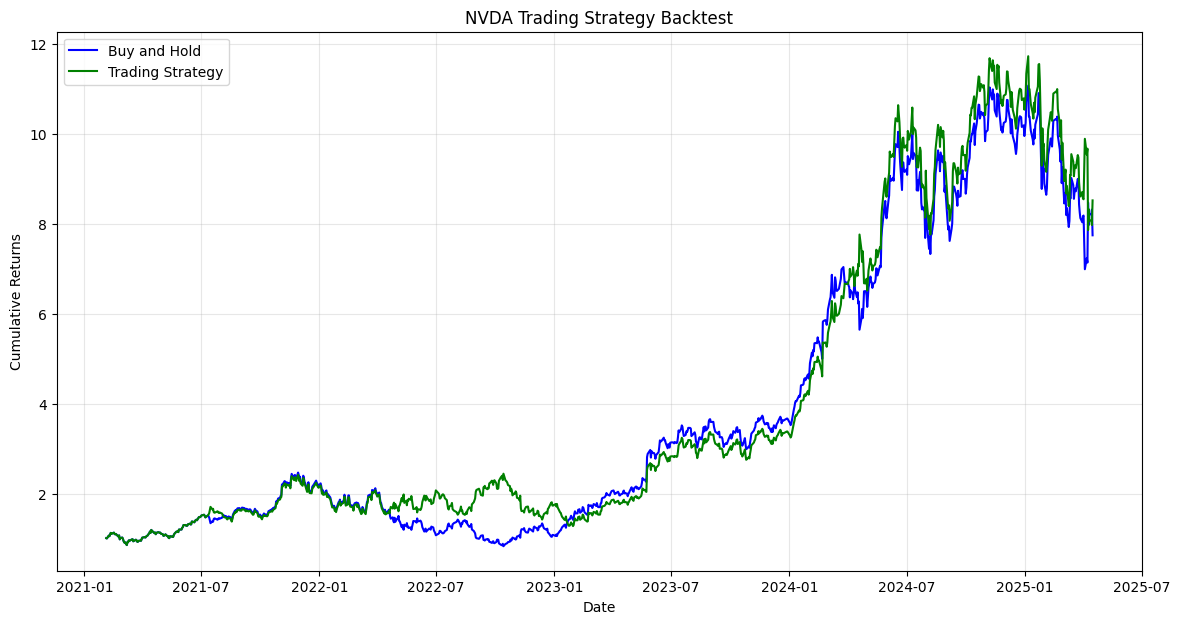

Strategy Performance Summary (NVDA):
Total trading days: 1055
Strategy return: 751.89%
Buy and hold return: 674.29%
Strategy outperformance: 77.60%
Sharpe ratio: 1.21


In [10]:
# Simple backtest of combined signal strategy
data['Position'] = 0  # 0: no position, 1: long, -1: short
position = 0
positions = []

for i in range(len(data)):
    if data['Combined_Signal'].iloc[i] == 'BUY' and position <= 0:
        position = 1  # Enter long position
    elif data['Combined_Signal'].iloc[i] == 'SELL' and position >= 0:
        position = -1  # Enter short position
    # In all other cases, maintain current position
    positions.append(position)

data['Position'] = positions

# Calculate strategy returns
data['Strategy_Returns'] = data['Position'].shift(1) * data['Returns']
data.dropna(subset=['Strategy_Returns'], inplace=True)

# Calculate cumulative returns
data['Cumulative_Returns'] = (1 + data['Returns'] / 100).cumprod()
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns'] / 100).cumprod()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative_Returns'], label='Buy and Hold', color='blue')
plt.plot(data.index, data['Cumulative_Strategy_Returns'], label='Trading Strategy', color='green')
plt.title(f'{ticker} Trading Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Performance metrics
total_days = len(data)
strategy_return = (data['Cumulative_Strategy_Returns'].iloc[-1] - 1) * 100
buy_hold_return = (data['Cumulative_Returns'].iloc[-1] - 1) * 100
sharpe_ratio = data['Strategy_Returns'].mean() / data['Strategy_Returns'].std() * np.sqrt(252)  # Annualized

print(f"Strategy Performance Summary ({ticker}):")
print(f"Total trading days: {total_days}")
print(f"Strategy return: {strategy_return:.2f}%")
print(f"Buy and hold return: {buy_hold_return:.2f}%")
print(f"Strategy outperformance: {strategy_return - buy_hold_return:.2f}%")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")